In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Idler state and Force Position Estimation ⚔️

In this notebook, different weight estimation models shall be researched. The objective is to approximate the position of the Force introduced and the idler state from the US-Sensors.

## Table of Content
1. [Random Forrest Classification 1](#RandomForrest1)
2. [Random Forrest Classification 2](#RandomForrest2)
3. [MLP Multilabel](#MLP)
4. [Comparison of all Classifiers](#Comparison)

If the goal is a multiclass-multilabel classification, a possible solution would be a MultioutputClassifier inside a simple base model. To keep things simpler, both labels first get treated separatly in two separate RandomForrestClassifiers.

The data is prepared in the Data_set_build.ipynb notebook and shall be saved in an db_idler_fft_2.csv file which gets fed into the current notebook. 
## Random Forrest 1: for Force Position🌳🌳🌳<a id="RandomForrest1"></a>
Goal: Find Position of Force introduced

Length of Dataset:  444005
Best validation accuracy: 0.93
Optimal parameters: {'max_depth': 10, 'n_estimators': 200}
Test Accuracy: 0.93
Test F1 Score: 0.92


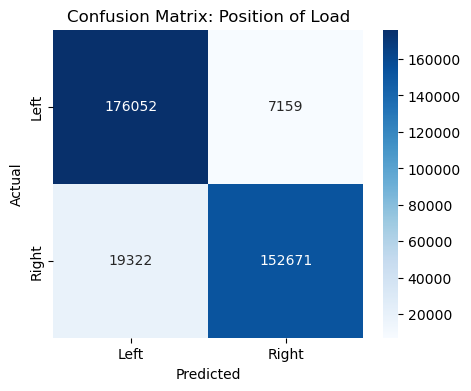

In [2]:
# Load dataset
#columns=['Timestamp', 'US horizontal','US vertical', 'Position', 'Idler'])
X = np.loadtxt('db_idler_fft_2.csv', delimiter=',')[:, [1,2]]  # Features
Y = np.loadtxt('db_idler_fft_2.csv', delimiter=',')[:, 3].astype(int)  # Position

print('Length of Dataset: ', len(X))

# Split data (80% training, 20% test) - Adjusted for faster optimization
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

# GridSearch with 5-fold cross-validation for hyperparameters
param_grid = {
    "n_estimators": [10, 50, 100, 200], #[10, 50, 100, 200]
    "max_depth": [2, 5, 10] #[2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(X_train, Y_train)

# Best model from validation
best_model = grid_search.best_estimator_
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")
print(f"Optimal parameters: {grid_search.best_params_}")

# Testing
Y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
test_f1 = f1_score(Y_test, Y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(Y_test, Y_test_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Position of Load")
plt.savefig("Pics/RF_Position.svg", format="svg")
plt.show()

# Classification Report
report_rf1 = classification_report(Y_test, Y_test_pred, output_dict=True)

## Random Forrest 2: for Idler State🌳🌳🌳<a id="RandomForrest2"></a>
Goal: Find Position of Force introduced
The two different idler states weren´t collected evenly, but with a discepance of the factor 4. Thus the RandomForestClassifier has to be configured class_weight="balanced" for both classes being represented evenly.

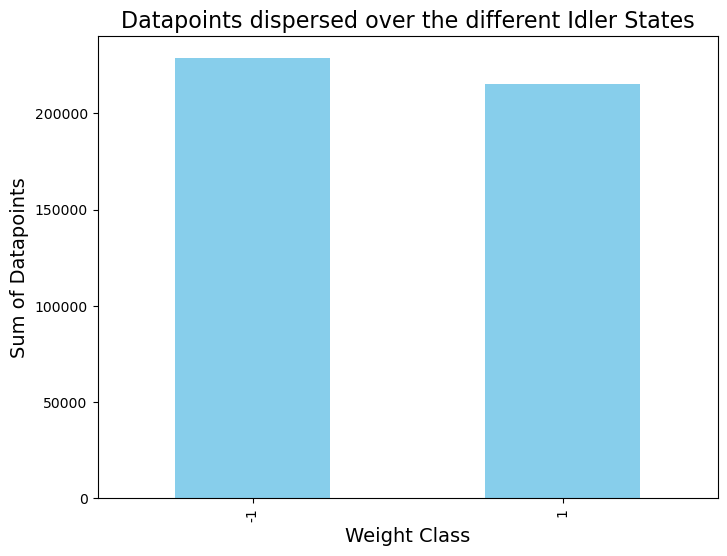

In [3]:
value_counts = pd.Series(Y.flatten()).value_counts().sort_index() 

plt.figure(figsize=(8,6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Datapoints dispersed over the different Idler States', fontsize=16)
plt.xlabel('Weight Class', fontsize=14)
plt.ylabel('Sum of Datapoints', fontsize=14)

# Zeige das Diagramm
plt.show()

Length of Dataset:  444005
Best validation accuracy: 0.70
Optimal parameters: {'max_depth': 2, 'n_estimators': 5}
Test Accuracy: 0.70
Test F1 Score: 0.79


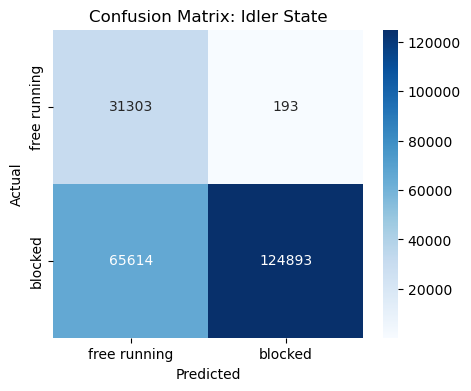

In [4]:
#columns=['Timestamp', 'US horizontal','US vertical', 'Position', 'Idler'])
X = np.loadtxt('db_idler_fft_2.csv', delimiter=',')[:, [1,2]]  # Features
Y = np.loadtxt('db_idler_fft_2.csv', delimiter=',')[:, 4].astype(int)  # Idler State

print('Length of Dataset: ', len(X))

# Split data (80% training, 20% test) - Adjusted for faster optimization
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# GridSearch with 5-fold cross-validation for hyperparameters
param_grid = {
    "n_estimators": [10, 5, 1], # [10, 50, 100, 200]
    "max_depth": [2, 1] #[2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight="balanced"), param_grid, cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(X_train, Y_train)

# Best model from validation
best_model = grid_search.best_estimator_
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")
print(f"Optimal parameters: {grid_search.best_params_}")

# Testing
Y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
test_f1 = f1_score(Y_test, Y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(Y_test, Y_test_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["free running", "blocked"], yticklabels=["free running", "blocked"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Idler State")
plt.savefig("Pics/RF_idler.svg", format="svg")
plt.show()

# Classification Report
report_rf2 = classification_report(Y_test, Y_test_pred, output_dict=True)

## MLP Multilabel: for both lables<a id="MLP"></a>

In [5]:
#columns=['Timestamp', 'US horizontal','US vertical', 'Position', 'Idler'])
X = np.loadtxt('db_idler_fft_2.csv', delimiter=',')[:, [1,2]]  # Features
Y = np.loadtxt('db_idler_fft_2.csv', delimiter=',')[:, [3,4]].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.99, random_state=42)

#This should have been fixed already with new Data_Set_build!
Y_train[Y_train == -1] = 0
Y_test[Y_test == -1] = 0
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # using the same transformer

# Define MLPClassifier inside MultiOutputClassifier
mlp = MLPClassifier(max_iter=1000, random_state=42)
multioutput_model = MultiOutputClassifier(mlp)

# GridSearch with 3-fold cross-validation MLPClassifier

param_grid = {
    'estimator__hidden_layer_sizes': [(2,), (5,), (8,), (10,)],  # Different sizes for hidden layers
    'estimator__activation': ['tanh', 'logistic'],  # ['relu', Activation functions
    'estimator__alpha': [0.0001, 0.001, 0.00001],  # Regularization strength
}

grid_search = GridSearchCV(multioutput_model, param_grid, cv=3, scoring='f1_micro', n_jobs=-1)
grid_search.fit(X_train_scaled, Y_train)

# calling the best model
best_model = grid_search.best_estimator_
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")
print(f"Best hyperparameters: {grid_search.best_params_}")

# Accuracy of the best model
Y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
f1 = f1_score(Y_test, Y_test_pred, average='micro')
print(f"Test Accuracy = (correct predictions)/(all predictions): {test_accuracy:.2f}")
print(f"Test F1 = : {f1:.2f}")
# Classification Report
report_mlp = classification_report(Y_test, Y_test_pred, zero_division=1, output_dict=True)

Best validation accuracy: 0.93
Best hyperparameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (10,)}
Test Accuracy = (correct predictions)/(all predictions): 0.85
Test F1 = : 0.93


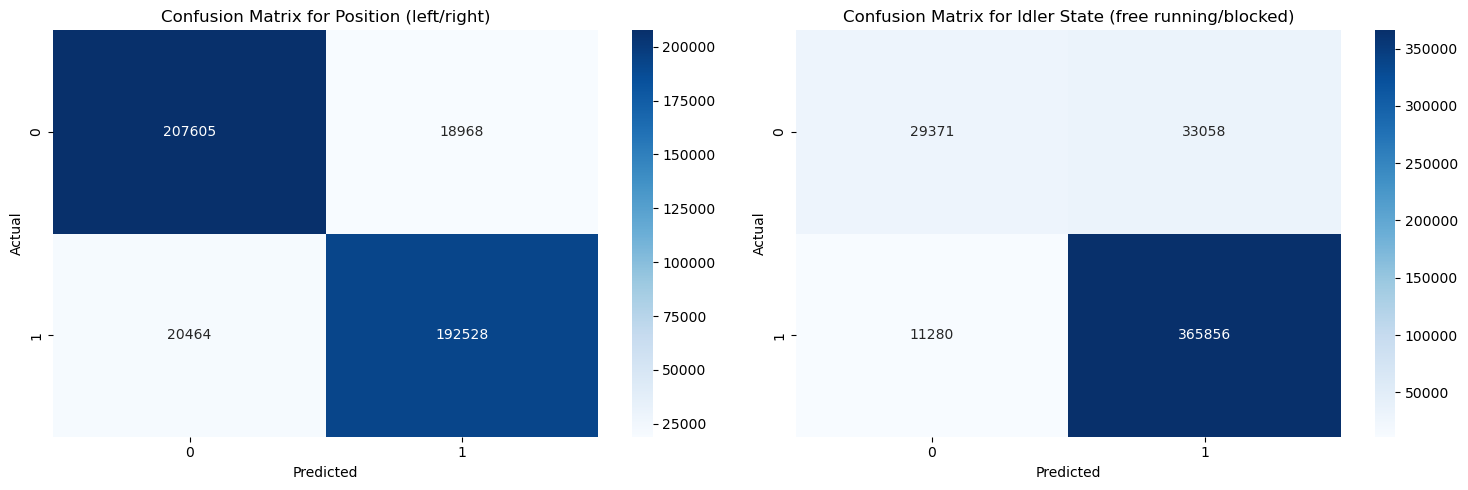

In [6]:
fig, axes = plt.subplots(1, Y.shape[1], figsize=(15, 5))

for i in range(Y.shape[1]):
    cm = confusion_matrix(Y_test[:, i], Y_test_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for Label {i}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
axes[0].set_title(f"Confusion Matrix for Position (left/right)")
axes[1].set_title(f"Confusion Matrix for Idler State (free running/blocked)")
plt.tight_layout()
plt.savefig("Pics/MLP_multilabel.svg", format="svg")
plt.show()

## Comparison of all Classifiers<a id="Comparison"></a>

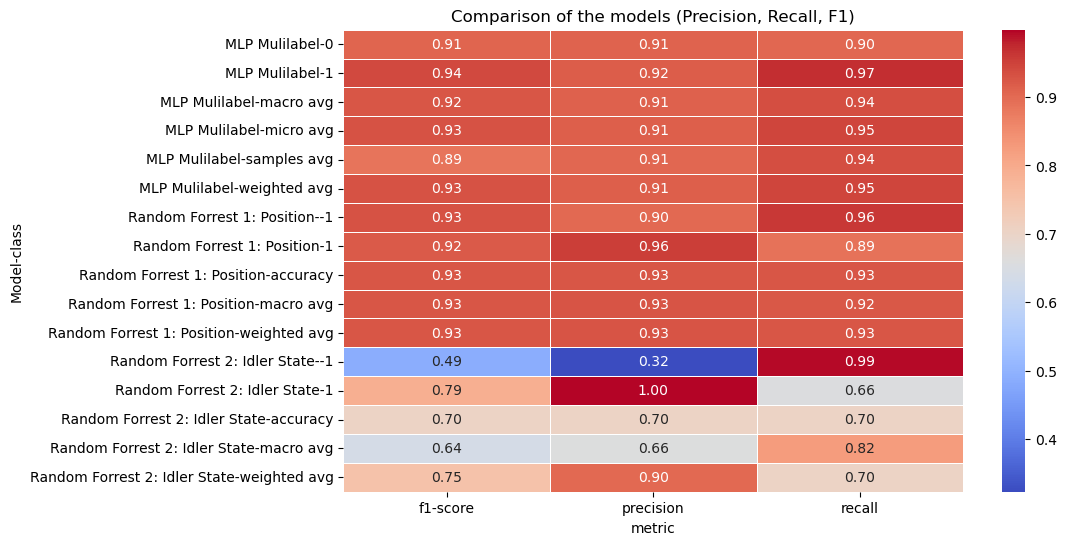

In [7]:
df1 = pd.DataFrame(report_rf1).T
df2 = pd.DataFrame(report_rf2).T
df3 = pd.DataFrame(report_mlp).T

# Modellnamen hinzufügen
df1["Model"] = "Random Forrest 1: Position"
df2["Model"] = "Random Forrest 2: Idler State"
df3["Model"] = "MLP Mulilabel"

df = pd.concat([df1, df2, df3])
df = df.reset_index().rename(columns={"index": "class"})
# Support separieren
df_support = df.pivot(index="Model", columns="class", values="support")
df_metrics = df.drop(columns=["support"]).melt(id_vars=["Model", "class"], var_name="metric", value_name="value")
df_pivot = df_metrics.pivot(index=["Model", "class"], columns="metric", values="value")

# Plotten
plt.figure(figsize=(10, 6))

sns.heatmap(df_pivot, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Comparison of the models (Precision, Recall, F1)")
plt.savefig("Pics/Model_comparison_Position_Idler.svg", format="svg")
plt.show()